In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
df_users = pd.read_csv('../data/df_users_train.csv')
df_users.head()

,BGGId,Rating,Username,isTest
0,121657,7.0,crash331,False
1,121657,7.0,randywilburn,False
2,121657,7.0,Lord Kalbut,True
3,121657,7.0,Vegas King,False
4,121657,7.0,Chilwd,False


# 1. Formar grupos

## 1.1 Verificar que todos los usuarios del test tengan al menos 3 juegos con nota mayor a 5

In [3]:
valid_games_count = df_users[(df_users['Rating'] > 5) & df_users.isTest].groupby('Username').size()

valid_users = valid_games_count[valid_games_count >= 3].index.tolist()
valid_users.__len__(), df_users[df_users.isTest].Username.unique().size

(77837, 77867)

In [4]:
df_users.loc[~df_users.Username.isin(valid_users), 'isTest'] = False
valid_users.__len__(), df_users[df_users.isTest].Username.unique().size

(77837, 77837)

## 1.2 Agrupar

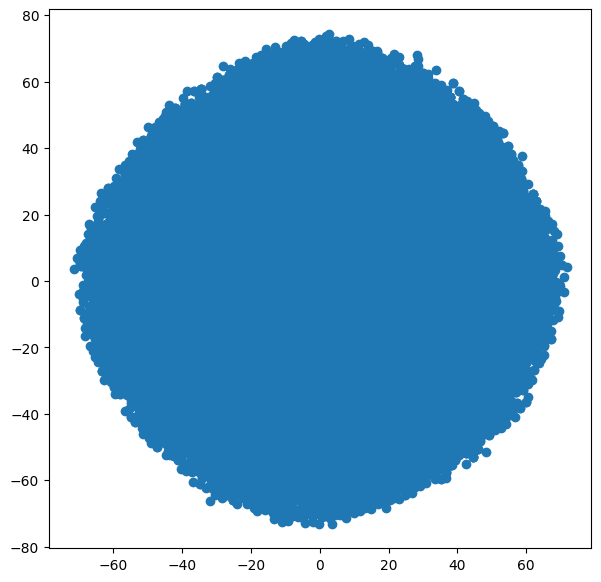

In [5]:
from openTSNE.sklearn import TSNE
import matplotlib.pyplot as plt

df_pivot = df_users[df_users.isTest].pivot_table(index='Username', columns='BGGId', values='Rating', fill_value=0)

tsne = TSNE(n_components=2)
proj = tsne.fit_transform(df_pivot.to_numpy())

plt.figure(figsize=(7, 7))
plt.scatter(proj[:, 0], proj[:, 1])
plt.show()

In [6]:
df_pivot = pd.DataFrame(proj, index=df_pivot.index)
df_pivot.head()

,0,1
Username,,
-=Yod@=-,48.483623,1.275676
-Johnny-,-2.537725,6.345264
-Morphling-,-14.201510,3.527036
-mIDE-,-20.735209,-27.977197
-toni-,-49.882000,-4.952956


In [8]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

grupos = []
users = list(df_pivot.index)
random.shuffle(users)


with tqdm(total=len(users), desc="Procesando usuarios") as pbar:
    while len(users) > 2:
        sz = min(np.random.randint(2, 8), len(users))

        knn = NearestNeighbors(n_neighbors=sz)
        user_list = list(df_pivot[df_pivot.index.isin(users)].index)
        knn.fit(df_pivot.loc[df_pivot.index.isin(users), :].to_numpy())
        candidates = knn.kneighbors(proj[df_pivot.index==users[0], :], return_distance=False)
        grp = [user_list[x] for x in candidates[:sz].flatten()]
        grupos.append(grp)
        for usr in grp:
            users.remove(usr)
        pbar.update(len(grp))


Procesando usuarios: 100%|██████████| 77837/77837 [07:04<00:00, 183.37it/s]


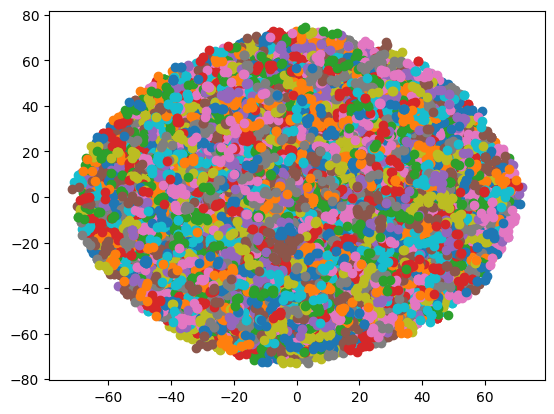

In [9]:
plt.figure()
for gr in grupos:
    aux = proj[df_pivot.index.isin(gr), :]
    plt.scatter(aux[:, 0], aux[:, 1])
plt.show()


In [10]:
df_groups = pd.DataFrame({'members': grupos})
df_groups.head()

,members
0,"[Sam Vimaire, Jhopper88]"
1,"[Kehmh, dracosf2]"
2,"[Drury67, sjackson080, mosaicu]"
3,"[CallMeTim72, calderyn, leochab, sirei, Abekon..."
4,"[alwaystang, Candorras, jmellby, Manpachism, C..."


In [11]:
df_groups.to_csv('../data/df_groups.csv', index=False)

In [12]:
df_groups = pd.read_csv('../data/df_groups.csv')

In [13]:
df_groups

,members
0,"['Sam Vimaire', 'Jhopper88']"
1,"['Kehmh', 'dracosf2']"
2,"['Drury67', 'sjackson080', 'mosaicu']"
3,"['CallMeTim72', 'calderyn', 'leochab', 'sirei'..."
4,"['alwaystang', 'Candorras', 'jmellby', 'Manpac..."
...,...
17259,"['markus_ecliptic', 'Loge82', 'hiddik']"
17260,"['gschloesser', 'Blipman', 'FEP 313', 'Vormwal..."
17261,"['rhmacdonald', 'BamBam1963', 'Radgamer', 'Dro..."
17262,"['Quizoid', 'crowmagnumb']"
